In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import yaml
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [10]:
with open ('config.yaml', 'r') as f:
    cfg = yaml.safe_load(f)
    

In [19]:
train = pd.read_csv(cfg['selary']['train_refactor'])
test = pd.read_csv(cfg['selary']['test_refactor'])

In [20]:

y_train = train['Credit_Score']
x_train = train.drop('Credit_Score', axis = 1)

X_train, X_val,  Y_train, Y_val = train_test_split(x_train, y_train, test_size =0.1, random_state =42)

Y_test = test['Credit_Score']
X_test = test.drop('Credit_Score', axis = 1)

X_train.shape, X_val.shape, X_test.shape

((35073, 24), (3897, 24), (7737, 24))

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)


In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train.values, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
Y_test = torch.tensor(Y_test, dtype=torch.long)
Y_val = torch.tensor(Y_val.values, dtype=torch.long)

C:\Users\snw12\AppData\Local\Temp\ipykernel_23404\1744470083.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.long)


In [23]:
train_t = TensorDataset(X_train, Y_train)
test_t = TensorDataset(X_test, Y_test)
train_val = TensorDataset(X_val, Y_val)

In [24]:
train_loader = DataLoader(train_t, batch_size=64, shuffle=True)
test_loader = DataLoader(test_t, batch_size=64, shuffle=True)
val_loader = DataLoader(train_val, batch_size=64, shuffle=True)

24
46.75741266129447
45.5335657322993
44.9425567134482
44.36143749366041
43.98315928509978
43.71043129924868
43.41486835088886
43.12770283808474
43.124280161544924
42.648720935719915
42.45354793501682
42.35752854190889
42.24105599082884
42.28398020541081
41.978237665090404
41.89443718800779
41.976751817054435
41.70664655087424
41.70809622377646
41.62536794826632
41.59426191009459
41.525279680236444
41.557015948608274
41.55180221893748
41.43701012798997
41.41160884841544
41.3912235215062
41.29367961258185
41.32256962139098
41.334221338639495
41.22557944059372
41.298827797663016
41.62759958818311
41.49609949647403
41.22171304655857
41.25284525312361
41.16245392404619
41.136840994240806
41.097993396344734
41.0205896506544
41.16562553605095
41.21134932119338
41.26462911338103
41.01568521241673
41.18654949840952
41.10074232836239
41.141243965899356
41.130920901650285
41.25367793489675
41.07848256826401
Overfitting early


<function matplotlib.pyplot.show(close=None, block=None)>

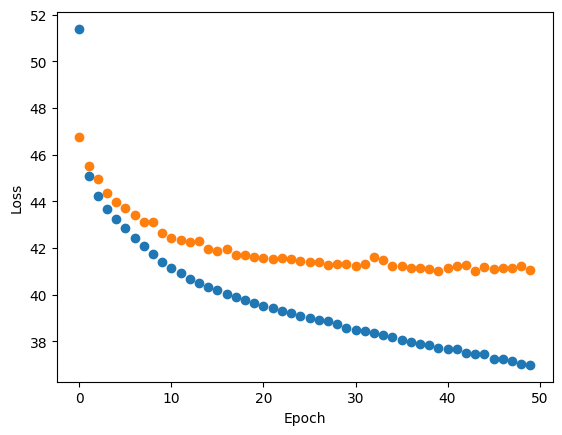

In [25]:
import torch.optim as optim
class CreditScore(nn.Module):
    def __init__(self, input_size):
        super(CreditScore, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = (self.fc4(x))
        return F.log_softmax(x, dim=1)
        #return x

size = X_train.shape[1]
model = CreditScore(size)

print(size)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

num_epochs = 200
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5
var_loss_x=[]
var_loss_y=[]
epoch_c=[]
for epch in range(num_epochs):
    epoch_c.append(epch)
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        #print( labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  * inputs.size(0)
        
        
    ephoch_loss = running_loss / len(train_loader)
    var_loss_x.append(ephoch_loss)
    #print(ephoch_loss)
    
    model.eval()
    var_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            #inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            var_loss +=loss.item()*inputs.size(0)
            
        ephoch_loss_2 = var_loss / len(val_loader)
        print(ephoch_loss_2)
        var_loss_y.append(ephoch_loss_2)
    if var_loss < best_val_loss:
        best_val_loss = var_loss
        early_stop_counter = 0
    else: 
        early_stop_counter +=1
        #if var_loss_y[-1] - min(var_loss_y) > 10.0:
        if early_stop_counter  > early_stop_patience:
            print('Overfitting early')
            break
        #elif ephoch_loss_2 > ephoch_loss:
         #   print('Early stopping')
          #  break
    #print(epoch_c, var_loss_x, var_loss_y)
plt.scatter(epoch_c,var_loss_x)   
plt.scatter(epoch_c, var_loss_y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show


In [247]:
model.eval()
predicted = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        predicted.extend(predict.numpy())
        true_labels.extend(labels.numpy())
accuracy = accuracy_score(true_labels, predicted) 
print(accuracy)

0.7246994959286546


In [20]:
if torch.cuda.is_available():
    print('GPU available')